In [ ]:
import numpy as np
from scipy.stats import linregress
import math
import pandas as pd
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.nn.utils import weight_norm
from torch.distributions.categorical import Categorical
import matplotlib.pyplot as plt
import plotly.express as px
import scipy
from scipy.stats import norm
from warnings import filterwarnings
filterwarnings('ignore')
import sys

# **Data Preparation**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# data = pd.read_pickle('/content/GARAN.E_snapshots_200ms.xz')
data = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/GARAN.E_snapshots_200ms.xz')

In [ ]:
order_book = {timestamp: entry['Orderbook'] for timestamp, entry in data.items()}

In [ ]:
data_10_to_6 = []
for d in list(data.items()):
  if d[0] >= pd.Timestamp('2018-10-08 10:00:00.000000+0300', tz='Europe/Istanbul') and d[0] < pd.Timestamp('2018-10-08 18:00:00.000000+0300', tz='Europe/Istanbul'):
    data_10_to_6.append(d)

In [ ]:
train_size = int(0.75 * len(data_10_to_6))
train_data = data_10_to_6[:train_size]
test_data = data_10_to_6[train_size:]

In [ ]:
# data_names = ['Orderbook', 'Executed', 'Added', 'Deleted']
orderbook_train, executed_train, added_train, deleted_train = [], [], [], []
for data in train_data:
  orderbook_train.append(data[1]['Orderbook'].tolist())
  executed_train.append(data[1]['Executed'])
  added_train.append(data[1]['Added'])
  deleted_train.append(data[1]['Deleted'])

orderbook_test, executed_test, added_test, deleted_test = [], [], [], []
for data in test_data:
  orderbook_test.append(data[1]['Orderbook'].tolist())
  executed_test.append(data[1]['Executed'])
  added_test.append(data[1]['Added'])
  deleted_test.append(data[1]['Deleted'])

In [ ]:
def transform_exe_add_del(input_data):
  input_transformed = []

  for ex in input_data:
    buy_quantity_sum = 0
    buy_weighted_price_sum = 0
    sell_quantity_sum = 0
    sell_weighted_price_sum = 0
    for i in ex:
      if i['side'] == 'buy':
        buy_weighted_price_sum += i['price'] * i['quantity']
        buy_quantity_sum += i['quantity']
      else:
        sell_weighted_price_sum += i['price'] * i['quantity']
        sell_quantity_sum += i['quantity']
    if buy_quantity_sum == 0:
      buy_weighted_avg_price = 0
    else:
      buy_weighted_avg_price = round(buy_weighted_price_sum / buy_quantity_sum, 3)
    if sell_quantity_sum == 0:
      sell_weighted_avg_price = 0
    else:
      sell_weighted_avg_price = round(sell_weighted_price_sum / sell_quantity_sum, 3)

    input_transformed.append([buy_weighted_avg_price, buy_quantity_sum, sell_weighted_avg_price, sell_quantity_sum])

  return input_transformed

In [ ]:
ex_train_transformed = torch.tensor(transform_exe_add_del(executed_train)).float()
ex_test_transformed = torch.tensor(transform_exe_add_del(executed_test)).float()
orderbook_train_top = torch.tensor([each[0] for each in orderbook_train])
orderbook_test_top = torch.tensor([each[0] for each in orderbook_test])

# **Data preprocessing**

In [ ]:
orderbook_train_sac = torch.tensor(orderbook_train).reshape(108000, 1, 10, 4).float()
ex_train_transformed_sac = ex_train_transformed.reshape(108000, 4).float()
prices_train = orderbook_train_top[:, 1:3].float()

In [ ]:
orderbook_test_sac = torch.tensor(orderbook_test).reshape(36000, 1, 10, 4).float()
ex_test_transformed_sac = ex_test_transformed.reshape(36000, 4).float()
prices_test = orderbook_test_top[:,1:3].float()

Seeing if there are any empty orderbook values in train and test set

In [ ]:
print(f"Any zero orderbooks in the training data:")
print(torch.all(orderbook_train_sac == 0, dim=3).any())
print(f"\nAny zero orderbooks in the test data:")
print(torch.all(orderbook_test_sac == 0, dim=3).any())

Any zero orderbooks in the training data:
tensor(True)

Any zero orderbooks in the test data:
tensor(False)


Find zero indices and remove them from training orderbook, execitions and prices

In [ ]:
mask = torch.all(orderbook_train_sac != 0, dim=3)[:, 0, 0]
orderbook_train_sac_nonzero = orderbook_train_sac[mask]
ex_train_transformed_sac_nonzero = ex_train_transformed_sac[mask]
prices_train_nonzero = prices_train[mask]

In [ ]:
print(orderbook_train_sac_nonzero.shape)
print(ex_train_transformed_sac_nonzero.shape)
print(prices_train_nonzero.shape)

torch.Size([91490, 1, 10, 4])
torch.Size([91490, 4])
torch.Size([91490, 2])


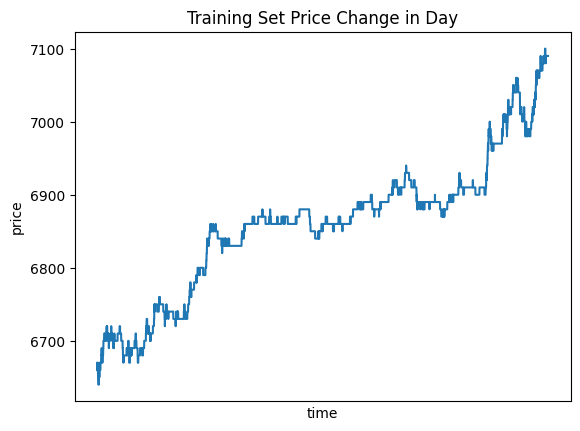

In [ ]:
plt.plot(range(len(prices_train_nonzero)), prices_train_nonzero[:,0])
plt.title('Training Set Price Change in Day')
plt.xlabel('time')
plt.xticks([])
plt.ylabel('price')
# plt.grid(True)
plt.show()

# **Test data preprocessing**

In [ ]:
orderbook_test_sac = torch.tensor(orderbook_test).reshape(36000, 1, 10, 4).float()
ex_test_transformed_sac = ex_test_transformed.reshape(36000, 4).float()
prices_test = orderbook_test_top[:,1:3].float()

In [ ]:
print(orderbook_test_sac.shape)
print(ex_test_transformed_sac.shape)
print(prices_test.shape)

torch.Size([36000, 1, 10, 4])
torch.Size([36000, 4])
torch.Size([36000, 2])


In [ ]:
mid_prices_test = (prices_test[:, 1] + prices_test[:, 0]) / 2

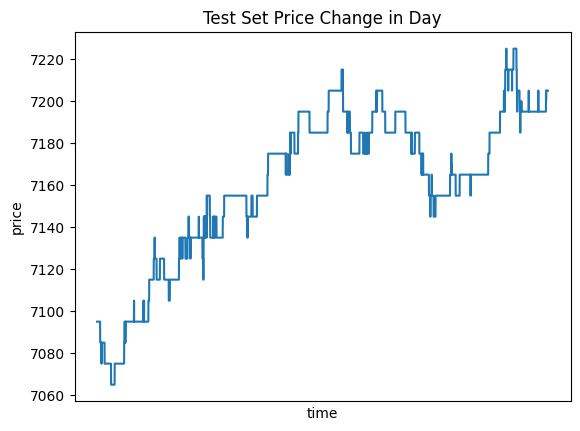

In [ ]:
plt.plot(mid_prices_test)
plt.title('Test Set Price Change in Day')
plt.xlabel('time')
plt.ylabel('price')
plt.xticks([])
plt.show()

# **Model Development**

#### **State transformation (feature engineering)**

compute volume imbalance in the orderbook to consider as a feature

In [ ]:
def state_func(orderbooks, executions):

  v_bid = orderbooks[:, :, :5, 0].sum(dim=-1)
  v_ask = orderbooks[:, :, :5, 3].sum(dim=-1)

  imbalance_current = (v_bid - v_ask) / (v_bid + v_ask)

  ex_qs_current = torch.log1p(executions[:, [1, 3]])

  state = torch.concat([imbalance_current, ex_qs_current], dim=-1)

  return state

In [ ]:
states = state_func(orderbook_train_sac_nonzero, ex_train_transformed_sac_nonzero)

In [ ]:
mid_prices_train_nonzero = (prices_train_nonzero[:, 1] + prices_train_nonzero[:, 0]) / 2

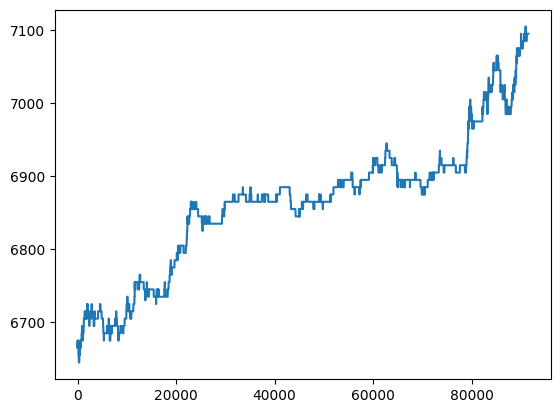

In [ ]:
plt.plot(mid_prices_train_nonzero)

#### **Analysis of features**

In [ ]:
whole = ex_train_transformed_sac_nonzero[:, [1, 3]]

In [ ]:
states[:,1]

tensor([ 0.0000, 11.2780,  9.0270,  ...,  0.0000,  0.0000,  0.0000])

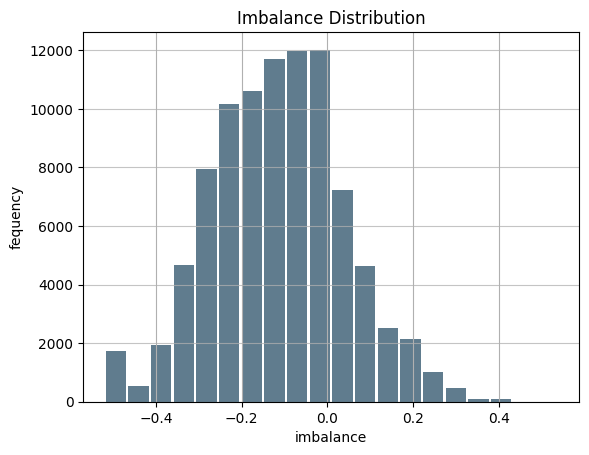

In [ ]:
size, scale = 1000, 10

imbalance = pd.Series(states[:, 0])

imbalance.plot.hist(grid=True, bins=20, rwidth=0.9,
                   color='#607c8e')
plt.title('Imbalance Distribution')
plt.xlabel('imbalance')
plt.ylabel('fequency')
plt.grid(axis='y', alpha=0.75)

Train set executed buy orders distribution

In [ ]:
buys = pd.Series(whole[:, 0])

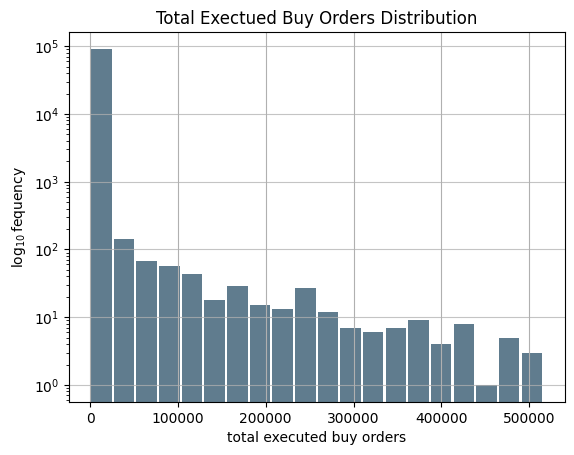

In [ ]:
buys.plot.hist(grid=True, bins=20, rwidth=0.9,
                   color='#607c8e')
plt.yscale('log')
plt.title('Total Exectued Buy Orders Distribution')
plt.xlabel('total executed buy orders')
plt.ylabel('$\log_{10}$fequency')
plt.grid(axis='y', alpha=0.75)

Train set executed sell orders distribution

In [ ]:
sells = pd.Series(whole[:, 1])

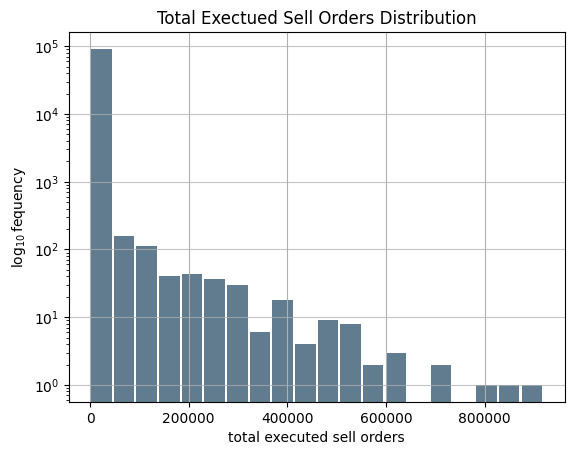

In [ ]:
sells.plot.hist(grid=True, bins=20, rwidth=0.9,
                   color='#607c8e')
plt.yscale('log')
plt.title('Total Exectued Sell Orders Distribution')
plt.xlabel('total executed sell orders')
plt.ylabel('$\log_{10}$fequency')
plt.grid(axis='y', alpha=0.75)

#### **Replay buffer**

In [ ]:
class ReplayBufferRaw:

  def __init__(self, capacity, env_len):

    self.capacity = capacity
    self.env_len = env_len
    self.ptr = 0 # pointer for circular buffer
    self.size = 0 # number of transitions in the buffer
    self.states = [None] * capacity # [self.size, env=1, n_features]
    self.actions = [None] * capacity # [self.size, env=1]
    self.rewards = [None] * capacity  # [self.size, 1]
    self.next_states = [None] * capacity # [self.size, env=1, n_features]
    self.dones = [None] * capacity # [self.size, env=1]

    self.ptr_list = []

  def add(self, state, action, next_state, reward, done):

    self.states[self.ptr] = state
    self.actions[self.ptr] = action
    self.next_states[self.ptr] = next_state
    self.rewards[self.ptr] = reward
    self.dones[self.ptr] = done

    self.ptr_list.append(self.ptr)

    # update pointer and size
    self.ptr = (self.ptr + 1) % self.capacity
    self.size = min(self.size + 1, self.capacity)

  def normalize_recent_rewards(self):


    extracted = torch.tensor((np.array(self.rewards[:self.size])[self.ptr_list]).tolist())

    # normalize them

    normalized_rewards = torch.sign(extracted) * torch.log1p(torch.abs(extracted))

    # mad = torch.median(torch.abs(extracted - torch.median(extracted)))
    # normalized_rewards = extracted / (mad + 1e-6)
    # print(normalized_rewards)


    for i, index in enumerate(self.ptr_list):

      # replace them with non-normal values
      self.rewards[index] = torch.tensor(normalized_rewards[i])


    # at the end empty the list
    self.ptr_list = []

    return extracted.mean()

  def sample(self, n_batches):

    sample_indices = np.random.choice(self.size, size=n_batches)

    states_return = torch.stack(self.states[:self.size])[sample_indices] # [n_batches, 1, n_features]
    actions_return = torch.stack(self.actions[:self.size])[sample_indices] # [n_batches, 1]
    next_states_return = torch.stack(self.next_states[:self.size])[sample_indices] # [n_batches, 1, n_features]

    mean_rewards_whole_buffer = round(torch.stack(self.rewards[:self.size]).mean().item(), 3)
    print(f"\nMean rewards of whole buffer: {mean_rewards_whole_buffer}")

    rewards_return = torch.stack(self.rewards[:self.size])[sample_indices] # [n_batches, 1, 1]

    # self.dones[-1] = torch.ones(1) # to set the last item of the total buffer to 1 flag

    dones_return = torch.stack(self.dones[:self.size])[sample_indices] # [n_batches, 1]

    return states_return, actions_return, next_states_return, rewards_return, dones_return, mean_rewards_whole_buffer

#### **Replay buffer for Sharpe ratio reward**

In [ ]:
def sharpe_shaped_rewards(rewards: torch.Tensor, window: int = 20, eps: float = 1e-8):
    rewards = rewards.float()
    T = rewards.shape[0]

    shaped = torch.zeros_like(rewards)

    for t in range(T):
        # Use expanding window until enough samples are available
        start = max(0, t - window + 1)
        window_rewards = rewards[start:t+1]

        # Compute rolling std
        mean = window_rewards.mean()
        std = window_rewards.std(unbiased=False)  # population std
        if std < eps:
            std = eps

        # Sharpe-style shaping: mean of return throughout the window/ volatility of the window
        shaped[t] = mean / std

    return shaped

In [ ]:
class ReplayBufferSharpe:

  def __init__(self, capacity, env_len):

    self.capacity = capacity
    self.env_len = env_len
    self.ptr = 0 # pointer for circular buffer
    self.size = 0 # number of transitions in the buffer
    self.states = [None] * capacity # [self.size, env=1, n_features]
    self.actions = [None] * capacity # [self.size, env=1]
    self.rewards = [None] * capacity  # [self.size, 1]
    self.next_states = [None] * capacity # [self.size, env=1, n_features]
    self.dones = [None] * capacity # [self.size, env=1]

    self.ptr_list = []

  def add(self, state, action, next_state, reward, done):

    self.states[self.ptr] = state
    self.actions[self.ptr] = action
    self.next_states[self.ptr] = next_state
    self.rewards[self.ptr] = reward
    self.dones[self.ptr] = done

    self.ptr_list.append(self.ptr)

    # update pointer and size
    self.ptr = (self.ptr + 1) % self.capacity
    self.size = min(self.size + 1, self.capacity)

  def normalize_recent_rewards(self):

    # print(self.rewards[:self.size])

    # extract non-normal values
    # print((np.array(self.rewards[:self.size])[self.ptr_list]).tolist())
    extracted = torch.tensor((np.array(self.rewards[:self.size])[self.ptr_list]).tolist())

    # if Sharpe is applied, normalization should not be done
    sharpe_rewards = sharpe_shaped_rewards(extracted, window=500)


    for i, index in enumerate(self.ptr_list):

      # replace them with original values
      self.rewards[index] = torch.tensor(sharpe_rewards[i])


    # at the end enpty the list
    self.ptr_list = []

    return extracted.mean()

  def sample(self, n_batches):

    sample_indices = np.random.choice(self.size, size=n_batches)

    states_return = torch.stack(self.states[:self.size])[sample_indices] # [n_batches, 1, n_features]
    actions_return = torch.stack(self.actions[:self.size])[sample_indices] # [n_batches, 1]
    next_states_return = torch.stack(self.next_states[:self.size])[sample_indices] # [n_batches, 1, n_features]

    mean_rewards_whole_buffer = round(torch.stack(self.rewards[:self.size]).mean().item(), 3)
    print(f"\nMean rewards of whole buffer: {mean_rewards_whole_buffer}")

    rewards_return = torch.stack(self.rewards[:self.size])[sample_indices] # [n_batches, 1, 1]

    # self.dones[-1] = torch.ones(1) # to set the last item of the total buffer to 1 flag

    dones_return = torch.stack(self.dones[:self.size])[sample_indices] # [n_batches, 1]

    return states_return, actions_return, next_states_return, rewards_return, dones_return, mean_rewards_whole_buffer

#### **SAC Class**

**Actor class**

In [ ]:
class Actor(nn.Module):
  def __init__(self,in_dim=3, action_dim=3):
    super().__init__()
    self.in_dim = in_dim
    self.action_dim = action_dim
    self.linear_1 = nn.Linear(in_dim, 128)
    self.linear_2 = nn.Linear(128, 64)
    self.linear_3 = nn.Linear(64, 32)
    self.linear_4 = nn.Linear(32, action_dim)
  def forward(self, state):
    x = F.relu(self.linear_1(state))
    x = F.relu(self.linear_2(x))
    x = F.relu(self.linear_3(x))
    logit = F.relu(self.linear_4(x))
    probs = F.softmax(logit, -1) # turn each three action values into probabilities
    dist = Categorical(probs)
    actions = dist.sample()

    log_probs = logit - torch.logsumexp(logit, dim=-1)

    # logsumexp does the exact same thing as the commented code below
    # log_probs = logit - torch.log(torch.sum(torch.exp(logit), dim=-1, keepdim=True))


    return actions, probs, log_probs

**Critic class**

In [ ]:
class Critic(nn.Module):
  def __init__(self, in_dim=3, action_dim=3):
    super().__init__()
    self.in_dim = in_dim
    self.action_dim = action_dim
    self.linear_1 = nn.Linear(in_dim, 128)
    self.linear_2 = nn.Linear(128, 64)
    self.linear_3 = nn.Linear(64, 32)
    self.linear_4 = nn.Linear(32, action_dim)
  def forward(self, state, action):
    x = F.relu(self.linear_1(state))
    x = F.relu(self.linear_2(x))
    x = F.relu(self.linear_3(x))
    q_values = F.relu(self.linear_4(x))

    # we do not return selected Q-values in discrete SAC unlike continuous SAC
    # where action space is infinite and we have to pass the selected Q-values

    return q_values

**Soft actor-critic class**

In [ ]:
class SAC(nn.Module):
  def __init__(self, tau=0.005, gamma=0.99, actor_lr=1e-4, critics_lr=1e-4, alpha_lr=1e-4):

    super().__init__()

    self.tau = tau
    self.gamma = gamma

    self.actor = Actor()
    self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=actor_lr)

    self.critic1 = Critic()
    self.critic1_optimizer = torch.optim.Adam(self.critic1.parameters(), lr=critics_lr)

    self.critic2 = Critic()
    self.critic2_optimizer = torch.optim.Adam(self.critic2.parameters(), lr=critics_lr)

    self.target_critic1 = Critic()
    self.target_critic2 = Critic()

    self.target_critic1.load_state_dict(self.critic1.state_dict())
    self.target_critic2.load_state_dict(self.critic2.state_dict())

    self.alpha = torch.tensor(np.log(2.), requires_grad=True)
    self.target_entropy = -np.log(3)
    self.alpha_optimizer = torch.optim.Adam([self.alpha], lr=alpha_lr)


  def forward(self):
    pass

  def actor_params(self):
    return self.actor.state_dict()

  def update_parameters(self, current_state, actions, next_state, reward, done):

    # Target Q computation

    with torch.no_grad():
      next_action, next_prob, next_log_prob = self.actor(next_state)

      # action shape: [n_batches, 1]
      # probability shape: [n_batches, 1, n_features]
      # log probability shape: [n_batches, 1, n_features]

      target_q1 = self.target_critic1(next_state, next_action) # shape[n_batches, 1, n_features]
      target_q2 = self.target_critic2(next_state, next_action) # shape[n_batches, 1, n_features]
      target_q = torch.min(target_q1, target_q2) # shape[n_batches, 1, n_features]

      # print(f"reward shape: {reward.shape}") # shape [n_batches, 1, 1]
      # print(f"done shape: {done.shape}") # shape [n_batches, 1]
      # print(f"target_q shape: {target_q.shape}") # shape [n_batches, 1, n_features]
      # print(f"log probability shape: {next_log_prob.shape}") # shape [n_batches, 1, n_features]


      V_target = torch.sum(next_prob * (target_q - self.alpha * next_log_prob), dim=-1, keepdim=True) # shape[n_batches, 1, 1]
      y = reward + self.gamma * (1 - done.unsqueeze(-1)) * V_target # shape[n_batches, 1, 1]


    # critic loss and update

    # since the critic returns all Qs, for computing critic loss, we
    # need the selected Qs for the actions

    q1 = self.critic1(current_state, actions) # [n_batches, 1, n_features]
    q2 = self.critic2(current_state, actions) # [n_batches, 1, n_features]

    selected_q1 = torch.gather(q1, -1, actions.unsqueeze(-1)) # [n_batches, 1, 1]
    selected_q2 = torch.gather(q2, -1, actions.unsqueeze(-1)) # [n_batches, 1, 1]

    critic_loss1 = F.mse_loss(selected_q1, y)
    critic_loss2 = F.mse_loss(selected_q2, y)

    self.critic1_optimizer.zero_grad()
    critic_loss1.backward()
    self.critic1_optimizer.step()

    self.critic2_optimizer.zero_grad()
    critic_loss2.backward()
    self.critic2_optimizer.step()


    # actor loss and update

    new_action, new_prob, new_log_prob = self.actor(current_state)

    # action shape: [n_batches, 1]
    # probability shape: [n_batches, 1, n_features]
    # log probability shape: [n_batches, 1, n_features]

    new_q = torch.min(self.critic1(current_state, new_action), self.critic2(current_state, new_action)) # shape[n_batches, 1, n_features]

    actor_loss = torch.sum((new_prob * (self.alpha * new_log_prob - new_q)), dim=-1, keepdim=True).mean()


    self.actor_optimizer.zero_grad()
    actor_loss.backward()
    self.actor_optimizer.step()


    # alpha loss and update


    # selected actions log probabilities
    selected_new_log_prob = torch.gather(new_log_prob, -1, new_action.unsqueeze(-1)) # shape[n_batches, 1, 1]


    alpha_loss = torch.mean(-self.alpha * (selected_new_log_prob + self.target_entropy).detach())

    self.alpha_optimizer.zero_grad()
    alpha_loss.backward()
    self.alpha_optimizer.step()


    # target critics soft update

    for param, target_param in zip(self.critic1.parameters(), self.target_critic1.parameters()):
      target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)
    for param, target_param in zip(self.critic2.parameters(), self.target_critic2.parameters()):
      target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)


    # logs

    dist = Categorical(probs=new_prob)
    entropy = dist.entropy()
    mean_entropy = round(torch.mean(entropy).item(), 3)
    print(f'Mean entropy: {mean_entropy}')
    print(f'Critic1 loss: {critic_loss1}\t Critic2 loss: {critic_loss2}')

    return critic_loss1, critic_loss2, mean_entropy

#### **DQN class**

In [ ]:
class Q(nn.Module):

  def __init__(self,in_dim=3, action_dim=3):
    super().__init__()
    self.in_dim = in_dim
    self.action_dim = action_dim
    self.linear_1 = nn.Linear(in_dim, 128)
    self.linear_2 = nn.Linear(128, 64)
    self.linear_3 = nn.Linear(64, 32)
    self.linear_4 = nn.Linear(32, action_dim)
  def forward(self, state):
    x = F.relu(self.linear_1(state))
    x = F.relu(self.linear_2(x))
    x = F.relu(self.linear_3(x))
    Q_values = F.relu(self.linear_4(x))

    return Q_values

In [ ]:
# state_sample [n_batches, 1, n_features]
# actions_sample [n_batches, 1]
# next_state_sample [n_batches, 1, n_features]
# reward_sample [n_batches, 1, 1]
# done_sample [n_batches, 1]
# mean_rewards_whole_buffer -> scalar

In [ ]:
class DQN:
  def __init__(self, gamma=0.99, epsilon=1, exploration_decay_rate = 0.99, target_update_fc=10, min_exploration=0.10):

    self.gamma = gamma
    self.epsilon = epsilon
    self.exploration_decay_rate = exploration_decay_rate
    self.target_update_fc = target_update_fc
    self.counter = 0
    self.min_exploration = min_exploration

    self.Q_online = Q()
    self.Q_target = Q()

    # Q-target should have the same parameters as the Q-online initially and periodically
    self.Q_target.load_state_dict(self.Q_online.state_dict())

    self.Q_online_optimizer = torch.optim.Adam(self.Q_online.parameters(), lr=1e-4)

  def update_parameters(self, states, actions, next_states, rewards, dones):
    # update epsilon
    self.epsilon = max([self.epsilon * self.exploration_decay_rate, self.min_exploration])

    # updating the counter to keep track of updating target network parameters
    self.counter += 1

    # target network computation
    with torch.no_grad():
      max_Q_target, _ = torch.max(self.Q_target(next_states), dim=-1) # output: [n_batches, 1]
      target = rewards + (1 - dones.unsqueeze(-1)) * self.gamma * max_Q_target.unsqueeze(-1) # output: [n_batches, 1, 1]


    # choose the Q values of the selected actions for the online network
    q_values = self.Q_online(states)

    selected_qs = torch.gather(q_values, -1, actions.unsqueeze(-1).unsqueeze(-1)) # output: [n_batches, 1, 1]

    # use selected Qs and target values to compute loss
    loss = F.mse_loss(selected_qs, target)

    # update Q network parameters
    self.Q_online_optimizer.zero_grad()
    loss.backward()
    self.Q_online_optimizer.step()


    # check the counter to see if we need to update target network parameters
    if(self.counter == self.target_update_fc):
      self.Q_target.load_state_dict(self.Q_online.state_dict())
      self.counter = 0

    return loss

#### **Position tracker for test evaluation**

The position tracker is designed to track the performance of agent at every time stamp. Since it replicates how agent would perform in real-time environment, it is useful and essential. Features such as total, realized and unrealized PnL can be retrieved from this class.
It is important to note that if positions are stacked (buy or sell) and one opposite action is chosen by agent, the whole position is closed.

In [ ]:
class PositionTracker:
  def __init__(self):
    self.entry_price = 0.0
    self.realized_pnl = torch.zeros(1) # Ensure realized_pnl is a tensor
    self.position_size = 0.0
    self.position = 'Flat'
    pass
  def update(self, action, price_now):
    if(action == 0): #buy
      ask_price = price_now[1] # action on the ask
      if(self.position == 'Flat'): # go from flat to long
        self.position = 'Long'
        self.position_size = 1
        self.entry_price = ask_price
      elif(self.position == 'Long'): #stack long positions
        self.entry_price = (self.entry_price * self.position_size + ask_price * 1) / (self.position_size + 1)
        self.position_size += 1
      elif(self.position == 'Short'): # close the short positon
        pnl = (self.entry_price - ask_price) * self.position_size
        self.realized_pnl += pnl
        self.entry_price = 0.0
        self.position_size = 0.0
        self.position = 'Flat'

    elif(action == 2): #short
      bid_price = price_now[0] #action on the bid
      if (self.position == 'Flat'):
        self.position = 'Short'
        self.position_size = 1
        self.entry_price = bid_price
      elif(self.position == 'Short'):
        self.entry_price = (self.entry_price * self.position_size + bid_price * 1) / (self.position_size + 1)
        self.position_size += 1
      elif(self.position == 'Long'): #close the long position
        pnl = (bid_price - self.entry_price) * self.position_size
        self.realized_pnl += pnl
        self.entry_price = 0.0
        self.position_size = 0.0
        self.position = 'Flat'
  def get_unrealized_pnl(self, price_now):
    ask_price = price_now[1]
    bid_price = price_now[0]
    if (self.position == 'Long'):
      # if you are long you look at the bid for unrealized pnl
      return (bid_price - self.entry_price) * self.position_size
    elif(self.position == 'Short'):
      # If you are short you look at the ask for unrealized pnl (immediate buy back price)
      return (self.entry_price - ask_price) * self.position_size
    else:
      return 0.0
  def get_total_pnl(self, price_before):
    return self.realized_pnl + self.get_unrealized_pnl(price_before)
  def is_flat(self):
    return self.position == 'Flat'

#### **Test data preprocessing**

In [ ]:
test_states = state_func(orderbook_test_sac, ex_test_transformed_sac)
len_test = test_states.size(0)

#### **SAC Main body normalized total PnL**

In [ ]:
episodes = 200

env_len = 5000

replay_buffer_SAC = ReplayBufferRaw(capacity=25000, env_len=env_len)


n_rollout_environment = 1
tot_data_len = orderbook_train_sac_nonzero.size(0)
lambda_ = 0.01

max_index = tot_data_len - env_len - 1
sample_range = np.arange(max_index)

entropy_list = []
test_pnl_SAC = []
test_pnl_SAC_realized = []

sac = SAC(tau=0.005, actor_lr=1e-4, critics_lr=1e-4, alpha_lr=1e-4)


# ------------------------------------------------------------------



for episode in range(episodes):

  print(50 * '--')
  print(f'\nEpisode {episode}\n')

  dones = torch.zeros(n_rollout_environment)

  sample_indices = np.random.choice(sample_range, size=n_rollout_environment)

  position_tracker = PositionTracker()
  for transition in range(env_len):

    current_states = states[sample_indices]

    actions, _, _ = sac.actor(current_states) # actions: [batches]

    position_tracker.update(actions, prices_train_nonzero[transition])

    next_states = states[sample_indices+1]


    # compute rewards
    reward = position_tracker.get_total_pnl(prices_train_nonzero[transition])


    sample_indices += 1


    if(transition + 1 == env_len):
      dones = torch.ones(n_rollout_environment)

    # store transition
    replay_buffer_SAC.add(current_states, actions, next_states, reward, dones)



  episode_mean_reward_SAC = replay_buffer_SAC.normalize_recent_rewards()


  for each in range(3):
    state_sample, actions_sample, next_state_sample, reward_sample, done_sample, mean_rewards_whole_buffer = replay_buffer_SAC.sample(n_batches=128)

    c_loss_1, c_loss_2, entropy = sac.update_parameters(state_sample, actions_sample, next_state_sample, reward_sample, done_sample)



    if(each == 0):
      entropy_list.append(entropy)


  # testing pnl on test data
  if(episode % 10 == 0 or episode+1 == episodes):
    print(50 * '**')
    print(f"\nTest PnL")
    position_tracker = PositionTracker()

    for t in range(len_test):
      state = test_states[t]

      actions, probs, log_probs = sac.actor(state)

      best_action = torch.argmax(probs)

      position_tracker.update(best_action, prices_test[t])

    tot_pnl = position_tracker.get_total_pnl(prices_test[t]).item()
    re_pnl = position_tracker.realized_pnl.item()
    test_pnl_SAC.append(tot_pnl)
    test_pnl_SAC_realized.append(re_pnl)
    print(f"Realized PnL: {re_pnl}")
    print(f"Total PnL: {tot_pnl}\n")
    print(50 * '**')

----------------------------------------------------------------------------------------------------

Episode 0

Episode mean reward: -0.03400000184774399

Mean rewards of whole buffer: 0.002
Mean entropy: 1.098
Critic1 loss: 1.1740740537643433	 Critic2 loss: 1.2039058208465576

Mean rewards of whole buffer: 0.002
Mean entropy: 1.098
Critic1 loss: 0.4974062442779541	 Critic2 loss: 0.5314082503318787

Mean rewards of whole buffer: 0.002
Mean entropy: 1.098
Critic1 loss: 1.002212643623352	 Critic2 loss: 1.0650899410247803
****************************************************************************************************

Test PnL
Realized PnL: 0.0
Total PnL: 49159.04296875

****************************************************************************************************
----------------------------------------------------------------------------------------------------

Episode 1

Episode mean reward: -0.24799999594688416

Mean rewards of whole buffer: -0.001
Mean entropy: 1.099
Crit

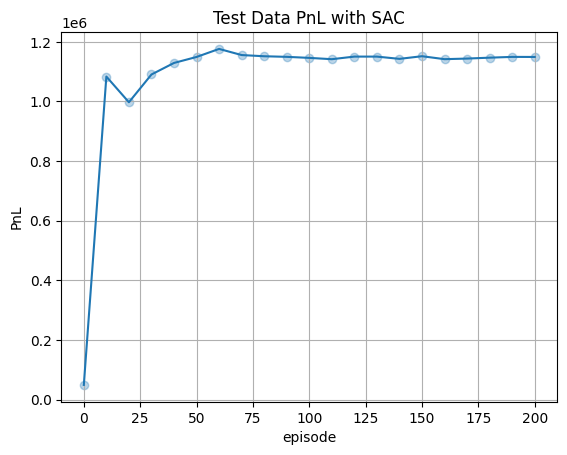

In [ ]:
plt.plot(np.arange(0, 201, 10), test_pnl_SAC)
plt.scatter(np.arange(0, 201, 10), test_pnl_SAC, alpha=0.3)
plt.title('Test Data PnL with SAC')
plt.xlabel('episode')
plt.ylabel('PnL')
plt.grid(True)
plt.show()

In [ ]:
position_tracker = PositionTracker()
test_time_pnl_list_total = []
test_time_pnl_list_realized = []
test_time_actions = []
for t in range(len(test_states)):
  state = test_states[t]

  # actions, probs, log_probs = actor_copy(state)
  actions, probs, log_probs = sac.actor(state)

  best_action = torch.argmax(probs)

  test_time_actions.append(best_action)

  position_tracker.update(best_action, prices_test[t])
  test_time_pnl_list_total.append(position_tracker.get_total_pnl(prices_test[t]).item())
  test_time_pnl_list_realized.append(position_tracker.realized_pnl.item())

Streaming output truncated to the last 5000 lines.
0.861
0.861
0.861
0.861
0.861
0.861
0.861
0.861
0.861
0.861
0.861
0.861
0.861
0.861
0.862
0.862
0.862
0.862
0.862
0.862
0.862
0.862
0.862
0.862
0.862
0.862
0.862
0.862
0.862
0.862
0.862
0.862
0.862
0.862
0.862
0.862
0.862
0.862
0.862
0.862
0.862
0.862
0.862
0.862
0.862
0.862
0.862
0.862
0.862
0.862
0.863
0.863
0.863
0.863
0.863
0.863
0.863
0.863
0.863
0.863
0.863
0.863
0.863
0.863
0.863
0.863
0.863
0.863
0.863
0.863
0.863
0.863
0.863
0.863
0.863
0.863
0.863
0.863
0.863
0.863
0.863
0.863
0.863
0.863
0.863
0.863
0.864
0.864
0.864
0.864
0.864
0.864
0.864
0.864
0.864
0.864
0.864
0.864
0.864
0.864
0.864
0.864
0.864
0.864
0.864
0.864
0.864
0.864
0.864
0.864
0.864
0.864
0.864
0.864
0.864
0.864
0.864
0.864
0.864
0.864
0.864
0.864
0.865
0.865
0.865
0.865
0.865
0.865
0.865
0.865
0.865
0.865
0.865
0.865
0.865
0.865
0.865
0.865
0.865
0.865
0.865
0.865
0.865
0.865
0.865
0.865
0.865
0.865
0.865
0.865
0.865
0.865
0.865
0.865
0.865
0.865
0.865
0.865
0

In [ ]:
acs = torch.stack(test_time_actions)
print(f"Number of buy actions: {len(acs[acs == 0])}")
print(f"Number of hold actions: {len(acs[acs == 1])}")
print(f"Number of sell actions: {len(acs[acs == 2])}")

33043
2957
0


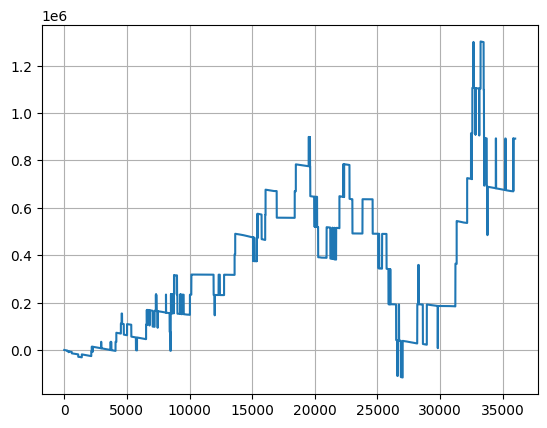

In [ ]:
plt.plot(range(len(test_time_pnl_list_total)), test_time_pnl_list_total)
plt.grid(True)

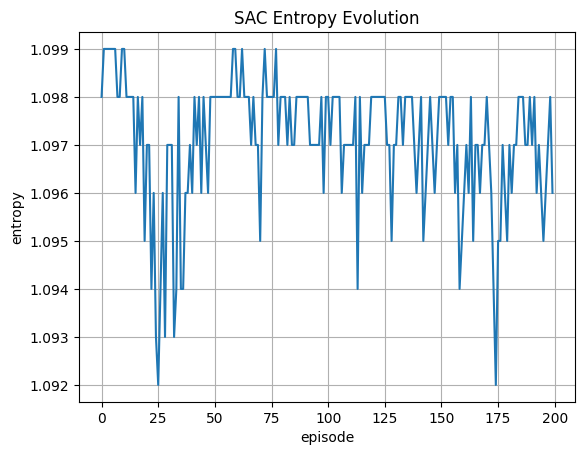

In [ ]:
plt.plot(range(len(entropy_list)), entropy_list)
plt.title('SAC Entropy Evolution')
plt.xlabel('episode')
plt.ylabel('entropy')
plt.grid(True)
plt.show()

In [ ]:
test_tot_pnl_training_raw = test_pnl_SAC
test_actions_raw = torch.stack(test_time_actions)
entropy_list_raw = entropy_list
actor_raw = Actor()
actor_raw.load_state_dict(sac.actor_params())

<All keys matched successfully>

#### **DQN Main body normalized total PnL**

In [ ]:
episodes = 200
# episodes = 2

env_len = 5000 # not equal to capacity. After every "buffer length" times of data storage we update the DRL
# env_len = 10

replay_buffer_DQN = ReplayBufferRaw(capacity=25000, env_len=env_len)


n_rollout_environment = 1
tot_data_len = orderbook_train_sac_nonzero.size(0)
lambda_ = 0.01

max_index = tot_data_len - env_len - 1
sample_range = np.arange(max_index)

critic_losses_dqn = []
exploration_list_dqn = []
mean_rewards_DQN = []
test_pnl_DQN = []

dqn = DQN(exploration_decay_rate=0.98)

# ------------------------------------------------------------------



for episode in range(episodes):

  print(50 * '--')
  print(f'\nEpisode {episode}\n')

  # reset done flag to zeros after each environment rollout is done
  dones = torch.zeros(n_rollout_environment)

  sample_indices = np.random.choice(sample_range, size=n_rollout_environment)


  for transition in range(env_len):

    current_states = states[sample_indices]

    # retrive Qs for the states
    qs_online = dqn.Q_online(current_states)

    if np.random.rand() > dqn.epsilon:
      # choose the max
      actions = torch.argmax(qs_online)

    else:
      # random action
      actions = torch.randint(0, 3, ())


    # next_states = torch.concat([states[sample_indices+1], next_inventory], dim=-1)
    next_states = states[sample_indices+1]


    # compute rewards
    reward = position_tracker.get_total_pnl(prices_train_nonzero[transition])


    sample_indices += 1

    if(transition + 1 == env_len):
      dones = torch.ones(n_rollout_environment)


    # store transition
    replay_buffer_DQN.add(current_states, actions, next_states, reward, dones)


  replay_buffer_DQN.normalize_recent_rewards()



  for each in range(3):
    state_sample, actions_sample, next_state_sample, reward_sample, done_sample, mean_rewards_whole_buffer = replay_buffer_DQN.sample(n_batches=128)

    critic_loss = dqn.update_parameters(state_sample, actions_sample, next_state_sample, reward_sample, done_sample)

    # store critic losses for the first sampling since the next updates have no effect on critic loss values
    if(each == 0):
      mean_rewards_DQN.append(mean_rewards_whole_buffer)
      critic_losses_dqn.append(critic_loss)
      exploration_list_dqn.append(dqn.epsilon)

  # testing pnl on test data
  if(episode % 10 == 0 or episode+1 == episodes):

    with torch.no_grad():
      print(50 * '**')
      print(f"Exploration: {dqn.epsilon}")
      print(f"\nTest PnL")
      position_tracker = PositionTracker()

      for t in range(len_test):
        state = test_states[t]

        # in inference always choose the maximum Q's action
        actions = torch.argmax(dqn.Q_online(state))

        position_tracker.update(actions, prices_test[t])

      tot_pnl = position_tracker.get_total_pnl(prices_test[t]).item()
      test_pnl_DQN.append(tot_pnl)

      print(f"PnL: {tot_pnl}\n")
      print(50 * '**')

----------------------------------------------------------------------------------------------------

Episode 0


Mean rewards of whole buffer: 0.002

Mean rewards of whole buffer: 0.002

Mean rewards of whole buffer: 0.002
****************************************************************************************************
Exploration: 0.9411919999999999

Test PnL
PnL: -1960892.625

****************************************************************************************************
----------------------------------------------------------------------------------------------------

Episode 1


Mean rewards of whole buffer: -0.0

Mean rewards of whole buffer: -0.0

Mean rewards of whole buffer: -0.0
----------------------------------------------------------------------------------------------------

Episode 2


Mean rewards of whole buffer: 0.001

Mean rewards of whole buffer: 0.001

Mean rewards of whole buffer: 0.001
--------------------------------------------------------------------

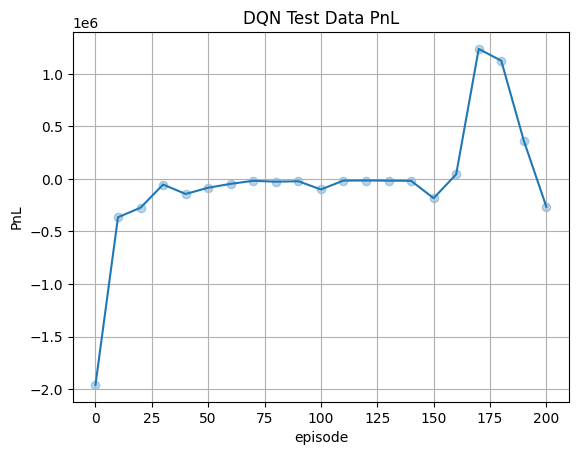

In [ ]:
# pnls
plt.plot(np.arange(0, 201, 10), test_pnl_DQN)
plt.scatter(np.arange(0, 201, 10), test_pnl_DQN, alpha=0.3)

plt.title('DQN Test Data PnL')
plt.xlabel('episode')
plt.ylabel('PnL')
plt.grid(True)
plt.show()

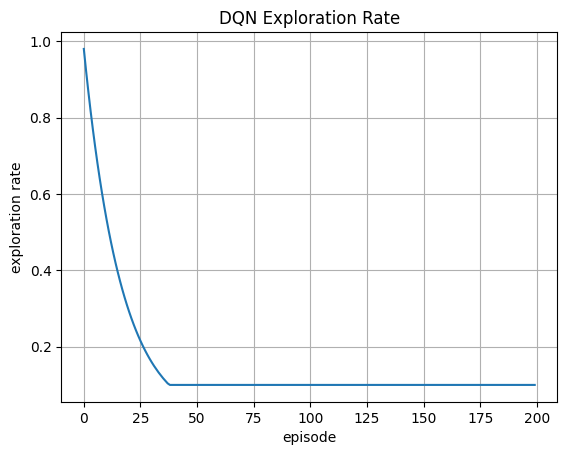

In [ ]:
plt.plot(exploration_list_dqn)
plt.title('DQN Exploration Rate')
plt.xlabel('episode')
plt.ylabel('exploration rate')
plt.grid(True)
plt.show()

**comparison between DQN and SAC**

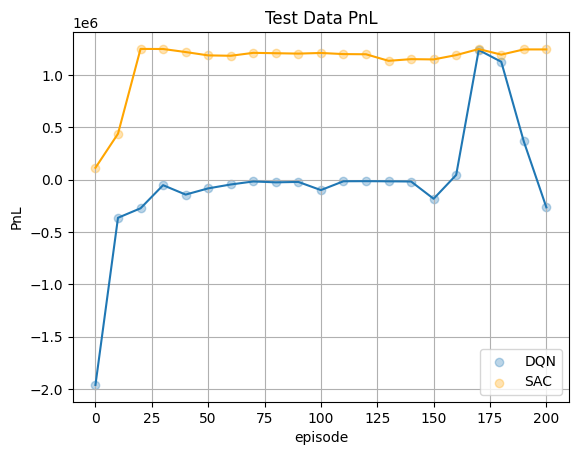

In [ ]:
# pnls
plt.plot(np.arange(0, 201, 10), test_pnl_DQN)
plt.scatter(np.arange(0, 201, 10), test_pnl_DQN, alpha=0.3, label='DQN')

plt.plot(np.arange(0, 201, 10), test_pnl_SAC, color='orange')
plt.scatter(np.arange(0, 201, 10), test_pnl_SAC, color='orange', alpha=0.3, label='SAC')

plt.title('Test Data PnL')
plt.xlabel('episode')
plt.ylabel('PnL')
plt.grid(True)
plt.legend()
plt.show()

#### **SAC Main body total PnL Sharpe reward**

In [ ]:

episodes = 200

env_len = 5000

replay_buffer_SAC = ReplayBufferSharpe(capacity=25000, env_len=env_len)


n_rollout_environment = 1
tot_data_len = orderbook_train_sac_nonzero.size(0)

max_index = tot_data_len - env_len - 1
sample_range = np.arange(max_index)


entropy_list = []
test_pnl_SAC = []
test_pnl_SAC_realized = []

sac = SAC(tau=0.005, actor_lr=1e-4, critics_lr=1e-4, alpha_lr=1e-4)


# ------------------------------------------------------------------


for episode in range(episodes):

  print(50 * '--')
  print(f'\nEpisode {episode}\n')

  dones = torch.zeros(n_rollout_environment)

  sample_indices = np.random.choice(sample_range, size=n_rollout_environment)

  position_tracker = PositionTracker()

  for transition in range(env_len):

    current_states = states[sample_indices]

    actions, _, _ = sac.actor(current_states) # actions: [n_batches]

    # report the chosen action to position tracker
    position_tracker.update(actions, prices_train_nonzero[transition])

    next_states = states[sample_indices+1]

    # compute rewards
    reward = position_tracker.get_total_pnl(prices_train_nonzero[transition])

    # update sample indices
    sample_indices += 1

    # if it is the last state in the evrionment, set done flag to true
    if(transition + 1 == env_len):
      dones = torch.ones(n_rollout_environment)

    # store transition
    replay_buffer_SAC.add(current_states, actions, next_states, reward, dones)


  # after we add "buffer_len" more transitions to our buffer
  # we sample N snapshots(state, action, next_state, reward) from the buffer and update parameters
  # then we go back to rollout and capture transitions using our updated policy

  # normalize rewards of the rollout which finished
  episode_mean_reward_SAC = replay_buffer_SAC.normalize_recent_rewards()


  # resample from the buffer and update multiple times (in this project 3) before going back to rollout

  for each in range(3):
    state_sample, actions_sample, next_state_sample, reward_sample, done_sample, mean_rewards_whole_buffer = replay_buffer_SAC.sample(n_batches=128)

    c_loss_1, c_loss_2, entropy = sac.update_parameters(state_sample, actions_sample, next_state_sample, reward_sample, done_sample)


    # store entropy for the first sampling
    if(each == 0):
      entropy_list.append(entropy)


  # agent evaluation on test set every 10 episodes and every 30 updates of the parameters

  if(episode % 10 == 0 or episode+1 == episodes):
    print(50 * '**')
    print(f"\nTest PnL")
    position_tracker = PositionTracker()

    for t in range(len_test):
      state = test_states[t]

      actions, probs, log_probs = sac.actor(state)

      # choosing the action with the highest probability
      best_action = torch.argmax(probs)

      position_tracker.update(best_action, prices_test[t])

    tot_pnl = position_tracker.get_total_pnl(prices_test[t]).item()
    re_pnl = position_tracker.realized_pnl.item()
    test_pnl_SAC.append(tot_pnl)
    test_pnl_SAC_realized.append(re_pnl)
    print(f"Realized PnL: {re_pnl}")
    print(f"Total PnL: {tot_pnl}\n")
    print(50 * '**')

----------------------------------------------------------------------------------------------------

Episode 0

Episode mean reward: -0.24400000274181366

Mean rewards of whole buffer: -0.011
Mean entropy: 1.096
Critic1 loss: 0.5536161661148071	 Critic2 loss: 0.46961894631385803

Mean rewards of whole buffer: -0.011
Mean entropy: 1.096
Critic1 loss: 0.5493584275245667	 Critic2 loss: 0.46822217106819153

Mean rewards of whole buffer: -0.011
Mean entropy: 1.097
Critic1 loss: 0.549129068851471	 Critic2 loss: 0.4553227126598358
****************************************************************************************************

Test PnL
Realized PnL: 0.0
Total PnL: -1960892.625

****************************************************************************************************
----------------------------------------------------------------------------------------------------

Episode 1

Episode mean reward: 0.019999999552965164

Mean rewards of whole buffer: -0.005
Mean entropy: 1.097
C

KeyboardInterrupt: 

**How the final total PnL changes through training**

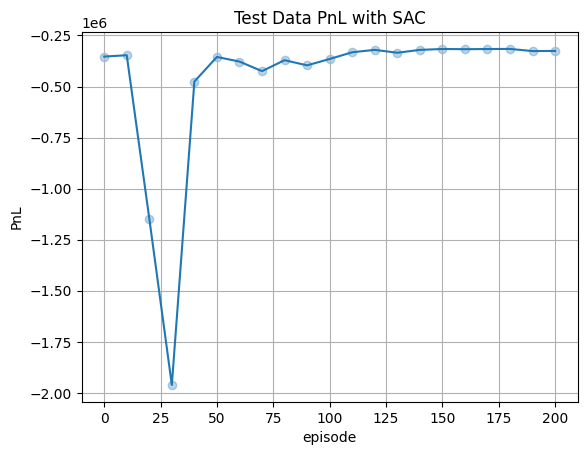

In [ ]:
plt.plot(np.arange(0, 201, 10), test_pnl_SAC)
plt.scatter(np.arange(0, 201, 10), test_pnl_SAC, alpha=0.3)
plt.title('Test Data Total PnL with SAC')
plt.xlabel('episode')
plt.ylabel('PnL')
plt.grid(True)
plt.show()

**How PnL changes as the final agent goes through the test data**

In [ ]:
position_tracker = PositionTracker()
test_time_pnl_list_total = []
test_time_pnl_list_realized = []
test_time_actions = []
for t in range(len(test_states)):

  state = test_states[t]

  # actions, probs, log_probs = actor_copy(state)
  actions, probs, log_probs = sac.actor(state)

  best_action = torch.argmax(probs)

  test_time_actions.append(best_action)

  position_tracker.update(best_action, prices_test[t])
  test_time_pnl_list_total.append(position_tracker.get_total_pnl(prices_test[t]).item())
  test_time_pnl_list_realized.append(position_tracker.realized_pnl.item())

Streaming output truncated to the last 5000 lines.
0.861
0.861
0.861
0.861
0.861
0.861
0.861
0.861
0.861
0.861
0.861
0.861
0.861
0.861
0.862
0.862
0.862
0.862
0.862
0.862
0.862
0.862
0.862
0.862
0.862
0.862
0.862
0.862
0.862
0.862
0.862
0.862
0.862
0.862
0.862
0.862
0.862
0.862
0.862
0.862
0.862
0.862
0.862
0.862
0.862
0.862
0.862
0.862
0.862
0.862
0.863
0.863
0.863
0.863
0.863
0.863
0.863
0.863
0.863
0.863
0.863
0.863
0.863
0.863
0.863
0.863
0.863
0.863
0.863
0.863
0.863
0.863
0.863
0.863
0.863
0.863
0.863
0.863
0.863
0.863
0.863
0.863
0.863
0.863
0.863
0.863
0.864
0.864
0.864
0.864
0.864
0.864
0.864
0.864
0.864
0.864
0.864
0.864
0.864
0.864
0.864
0.864
0.864
0.864
0.864
0.864
0.864
0.864
0.864
0.864
0.864
0.864
0.864
0.864
0.864
0.864
0.864
0.864
0.864
0.864
0.864
0.864
0.865
0.865
0.865
0.865
0.865
0.865
0.865
0.865
0.865
0.865
0.865
0.865
0.865
0.865
0.865
0.865
0.865
0.865
0.865
0.865
0.865
0.865
0.865
0.865
0.865
0.865
0.865
0.865
0.865
0.865
0.865
0.865
0.865
0.865
0.865
0.865
0

In [ ]:
acs = torch.stack(test_time_actions)
print(f"Number of buy actions: {len(acs[acs == 0])}")
print(f"Number of hold actions: {len(acs[acs == 1])}")
print(f"Number of sell actions: {len(acs[acs == 2])}")

0
0
36000


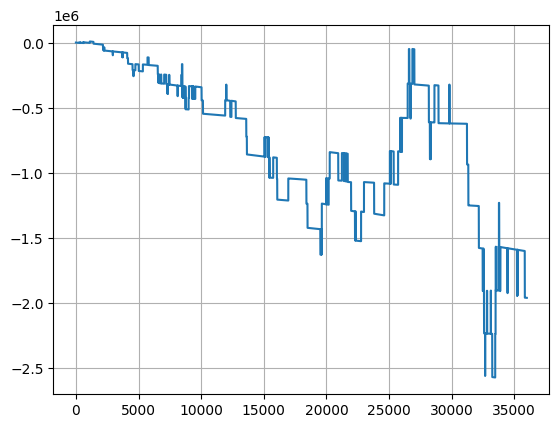

In [ ]:
plt.plot(range(len(test_time_pnl_list_total)), test_time_pnl_list_total)
plt.title('Total PnL Change on Test Set')
plt.xlabel('time')
plt.ylabel('total PnL')
plt.grid(True)

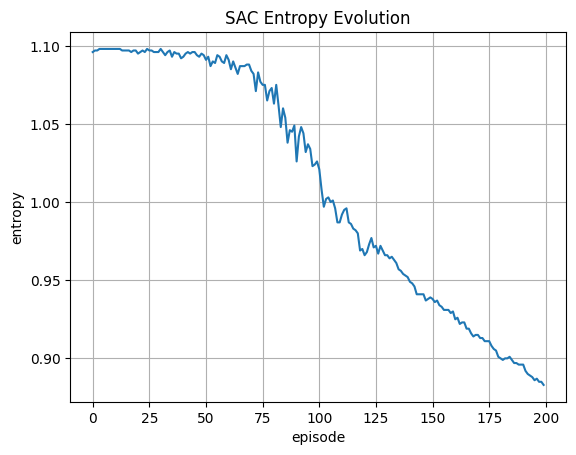

In [ ]:
plt.plot(range(len(entropy_list)), entropy_list)
plt.title('SAC Entropy Evolution')
plt.xlabel('episode')
plt.ylabel('entropy')
plt.grid(True)
plt.show()

In [ ]:
test_tot_pnl_training_sharpe = test_pnl_SAC
test_actions_sharpe = torch.stack(test_time_actions)
entropy_list_sharpe = entropy_list
actor_sharpe = Actor()
actor_sharpe.load_state_dict(sac.actor_params())

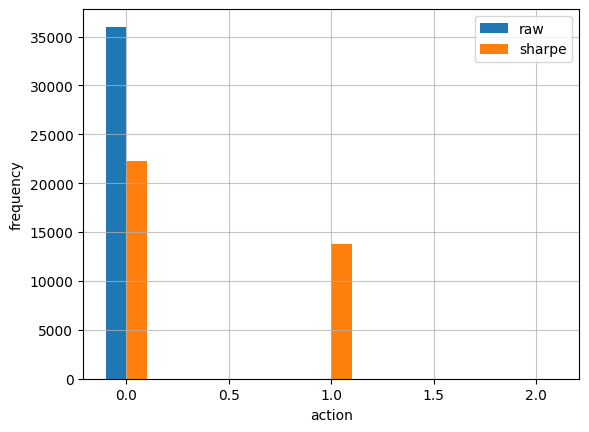

In [ ]:
# torch.concat([test_actions_raw, test_actions_sharpe], dim=0)
labels=['raw', 'sharpe']
both = torch.concat([test_actions_raw.unsqueeze(-1), test_actions_sharpe.unsqueeze(-1)], dim=-1).numpy()
plt.hist(both, label=labels, bins=[-0.5, 0.5, 1.5, 2.5], rwidth=0.2)
# plt.xticks(['buy', 'hold', 'sell'])
plt.xlabel('action')
plt.ylabel('frequency')
plt.grid(alpha=0.75)
plt.legend()

#### **SAC Main body realized PnL Sharpe reward**

In [ ]:
episodes = 200

max_inventory = 5000

env_len = 5000

replay_buffer_SAC = ReplayBufferSharpe(capacity=25000, env_len=env_len)


n_rollout_environment = 1
tot_data_len = orderbook_train_sac_nonzero.size(0)
lambda_ = 0.01

max_index = tot_data_len - env_len - 1
sample_range = np.arange(max_index)


entropy_list = []
test_pnl_SAC = []
test_pnl_SAC_realized = []

sac = SAC(tau=0.005, actor_lr=1e-4, critics_lr=1e-4, alpha_lr=1e-4)


# ------------------------------------------------------------------



for episode in range(episodes):

  print(50 * '--')
  print(f'\nEpisode {episode}\n')

  dones = torch.zeros(n_rollout_environment)


  sample_indices = np.random.choice(sample_range, size=n_rollout_environment)


  position_tracker = PositionTracker()
  for transition in range(env_len):

    current_states = states[sample_indices]

    actions, _, _ = sac.actor(current_states) # actions: [batches]


    # keep position tracker updated about the chosen action
    position_tracker.update(actions, prices_train_nonzero[transition])


    # next_states = torch.concat([states[sample_indices+1], next_inventory], dim=-1)
    next_states = states[sample_indices+1]


    # compute rewards (using realized PnL only)

    reward = position_tracker.realized_pnl


    sample_indices += 1

    if(transition + 1 == env_len):
      dones = torch.ones(n_rollout_environment)


    # store transition
    replay_buffer_SAC.add(current_states, actions, next_states, reward, dones)


  episode_mean_reward_SAC = replay_buffer_SAC.normalize_recent_rewards()

  print(f'Episode mean reward: {episode_mean_reward_SAC}')

  for each in range(3):
    state_sample, actions_sample, next_state_sample, reward_sample, done_sample, mean_rewards_whole_buffer = replay_buffer_SAC.sample(n_batches=128)

    c_loss_1, c_loss_2, entropy = sac.update_parameters(state_sample, actions_sample, next_state_sample, reward_sample, done_sample)


    if(each == 0):
      entropy_list.append(entropy)


  # testing pnl on test data
  if(episode % 10 == 0 or episode+1 == episodes):
    print(50 * '**')
    print(f"\nTest PnL")
    # position_tracker = PositonTracker()
    position_tracker = PositionTracker()

    for t in range(len_test):
      state = test_states[t]

      actions, probs, log_probs = sac.actor(state)

      best_action = torch.argmax(probs)

      position_tracker.update(best_action, prices_test[t])

    tot_pnl = position_tracker.get_total_pnl(prices_test[t]).item()
    re_pnl = position_tracker.realized_pnl.item()
    test_pnl_SAC.append(tot_pnl)
    test_pnl_SAC_realized.append(re_pnl)
    print(f"Realized PnL: {re_pnl}")
    print(f"Total PnL: {tot_pnl}\n")
    print(50 * '**')

----------------------------------------------------------------------------------------------------

Episode 0

Episode mean reward: -15667.814453125

Mean rewards of whole buffer: -1459928039424.0
Mean entropy: 1.098
Critic1 loss: 2.282201489070602e+24	 Critic2 loss: 2.282201489070602e+24

Mean rewards of whole buffer: -1459928039424.0
Mean entropy: 1.098
Critic1 loss: 2.2246666707654543e+24	 Critic2 loss: 2.2246666707654543e+24

Mean rewards of whole buffer: -1459928039424.0
Mean entropy: 1.098
Critic1 loss: 2.2246669589958305e+24	 Critic2 loss: 2.2246669589958305e+24
****************************************************************************************************

Test PnL
Realized PnL: -779.3798828125
Total PnL: -84329.7265625

****************************************************************************************************
----------------------------------------------------------------------------------------------------

Episode 1

Episode mean reward: -18355.046875

Mean

**How the final test set realized and total PnL evolved**

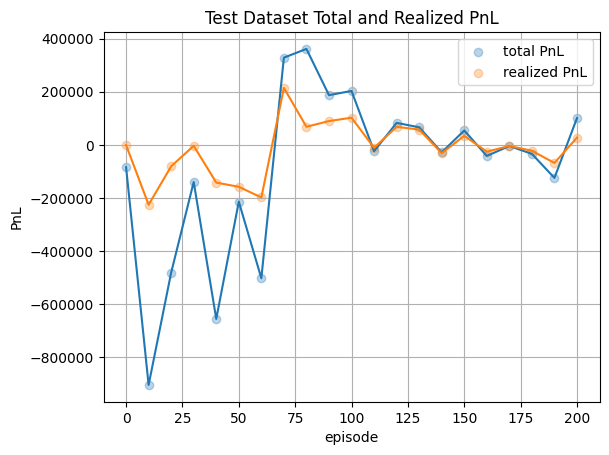

In [ ]:
plt.plot(np.arange(0, 201, 10), test_pnl_SAC)
plt.scatter(np.arange(0, 201, 10), test_pnl_SAC, alpha=0.3, label='total PnL')
plt.plot(np.arange(0, 201, 10), test_pnl_SAC_realized)
plt.scatter(np.arange(0, 201, 10), test_pnl_SAC_realized, alpha=0.3, label='realized PnL')
plt.title('Test Dataset Total and Realized PnL')
plt.xlabel('episode')
plt.ylabel('PnL')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
position_tracker = PositionTracker()
test_time_pnl_list_total = []
test_time_pnl_list_realized = []
test_time_actions = []
position_size_list = []
for t in range(len(test_states)):
  print(round(t/len(test_states), 3))
  state = test_states[t]

  # actions, probs, log_probs = actor_copy(state)
  actions, probs, log_probs = sac.actor(state)

  best_action = torch.argmax(probs)

  test_time_actions.append(best_action)

  position_tracker.update(best_action, prices_test[t])
  test_time_pnl_list_total.append(position_tracker.get_total_pnl(prices_test[t]).item())
  test_time_pnl_list_realized.append(position_tracker.realized_pnl.item())
  position_size_list.append(position_tracker.position_size)

Streaming output truncated to the last 5000 lines.
0.861
0.861
0.861
0.861
0.861
0.861
0.861
0.861
0.861
0.861
0.861
0.861
0.861
0.861
0.862
0.862
0.862
0.862
0.862
0.862
0.862
0.862
0.862
0.862
0.862
0.862
0.862
0.862
0.862
0.862
0.862
0.862
0.862
0.862
0.862
0.862
0.862
0.862
0.862
0.862
0.862
0.862
0.862
0.862
0.862
0.862
0.862
0.862
0.862
0.862
0.863
0.863
0.863
0.863
0.863
0.863
0.863
0.863
0.863
0.863
0.863
0.863
0.863
0.863
0.863
0.863
0.863
0.863
0.863
0.863
0.863
0.863
0.863
0.863
0.863
0.863
0.863
0.863
0.863
0.863
0.863
0.863
0.863
0.863
0.863
0.863
0.864
0.864
0.864
0.864
0.864
0.864
0.864
0.864
0.864
0.864
0.864
0.864
0.864
0.864
0.864
0.864
0.864
0.864
0.864
0.864
0.864
0.864
0.864
0.864
0.864
0.864
0.864
0.864
0.864
0.864
0.864
0.864
0.864
0.864
0.864
0.864
0.865
0.865
0.865
0.865
0.865
0.865
0.865
0.865
0.865
0.865
0.865
0.865
0.865
0.865
0.865
0.865
0.865
0.865
0.865
0.865
0.865
0.865
0.865
0.865
0.865
0.865
0.865
0.865
0.865
0.865
0.865
0.865
0.865
0.865
0.865
0.865
0

In [ ]:
acs = torch.stack(test_time_actions)
print(len(acs[acs == 0]))
print(len(acs[acs == 1]))
print(len(acs[acs == 2]))

17608
5190
13202


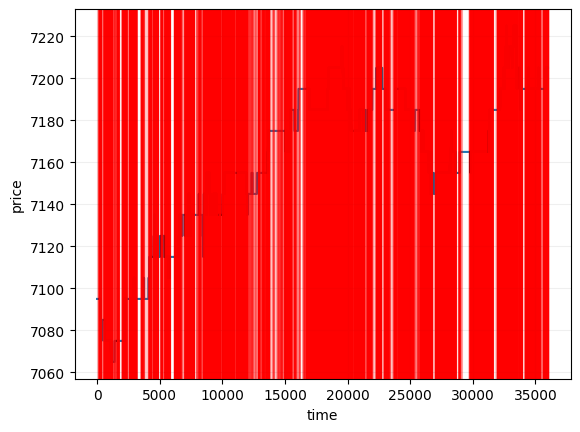

In [ ]:
plt.plot(mid_prices_test)
for i in torch.where(acs == 2)[0].numpy():
  plt.axvline(i, color='r', alpha=0.2)
plt.xlabel('time')
plt.ylabel('price')
# plt.title('Sell Actions on Test Set')
plt.grid(alpha=0.2)
plt.show()

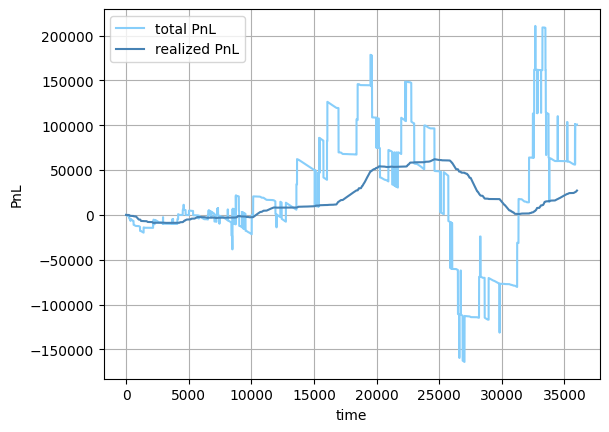

In [ ]:
plt.plot(range(len(test_time_pnl_list_total)), test_time_pnl_list_total, color='#87CEFA', label='total PnL')
plt.plot(range(len(test_time_pnl_list_realized)), test_time_pnl_list_realized, color='#4682B4', label='realized PnL')
# for i in torch.where(acs == 2)[0].numpy():
#   plt.axvline(i, color='r', alpha=0.2)
# plt.title('Total and Realized Equity Curve Throughout Test Data ')
plt.xlabel('time')
plt.ylabel('PnL')
plt.legend()
plt.grid(True)

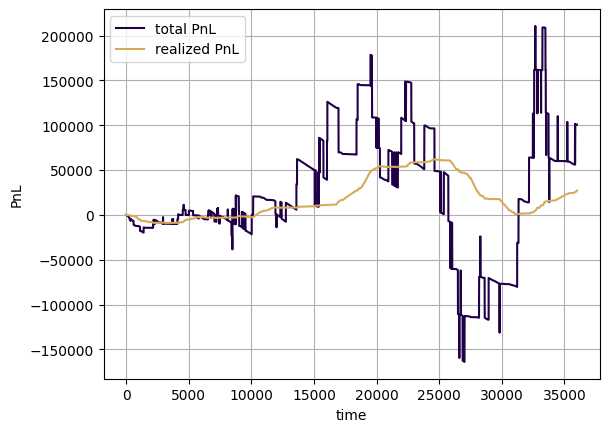

In [ ]:
plt.plot(range(len(test_time_pnl_list_total)), test_time_pnl_list_total, color='#200047', label='total PnL')
plt.plot(range(len(test_time_pnl_list_realized)), test_time_pnl_list_realized, color='#d7aa5b', label='realized PnL')
# for i in torch.where(acs == 2)[0].numpy():
#   plt.axvline(i, color='r', alpha=0.2)
# plt.title('Total and Realized Equity Curve Throughout Test Data ')
plt.xlabel('time')
plt.ylabel('PnL')
plt.legend()
plt.grid(True)

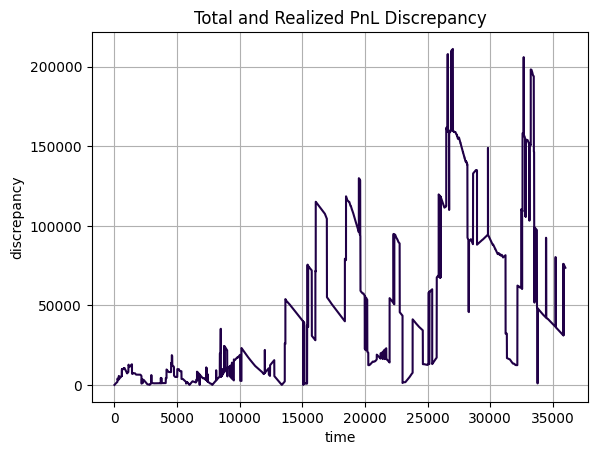

In [ ]:
plt.plot(abs(np.array(test_time_pnl_list_total) - np.array(test_time_pnl_list_realized)), color='#200047')
plt.xlabel('time')
plt.ylabel('discrepancy')
plt.title('Total and Realized PnL Discrepancy')
plt.grid(True)

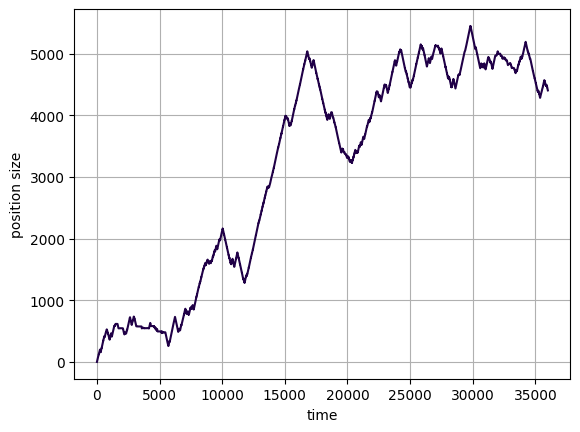

In [ ]:
plt.plot(position_size_list, color='#200047')
plt.xlabel('time')
plt.ylabel('position size')
plt.grid(True)

In [ ]:
print(f"total pnl Sharpe ratio: {np.mean(test_time_pnl_list_total)/ np.std(test_time_pnl_list_total)}")
print(f"realized pnl Sharpe ratio: {np.mean(test_time_pnl_list_realized)/ np.std(test_time_pnl_list_realized)}")

total pnl Sharpe ratio: 0.34128675598619207
realized pnl Sharpe ratio: 0.784728951178489


In [ ]:
print(f"final total pnl: {test_time_pnl_list_total[-1]}")
print(f"final realized pnl: {test_time_pnl_list_realized[-1]}")
print(f"biggest total drawdown: {np.min(test_time_pnl_list_total)}")
print(f"biggest realized drawdown: {np.min(test_time_pnl_list_realized)}")
print(f"biggest total profit: {np.max(test_time_pnl_list_total)}")
print(f"biggest realized profit: {np.max(test_time_pnl_list_realized)}")

final total pnl: 100808.9140625
final realized pnl: 27169.763671875
biggest total drawdown: -164059.609375
biggest realized drawdown: -8975.759765625
biggest total profit: 210876.25
biggest realized profit: 62187.3203125


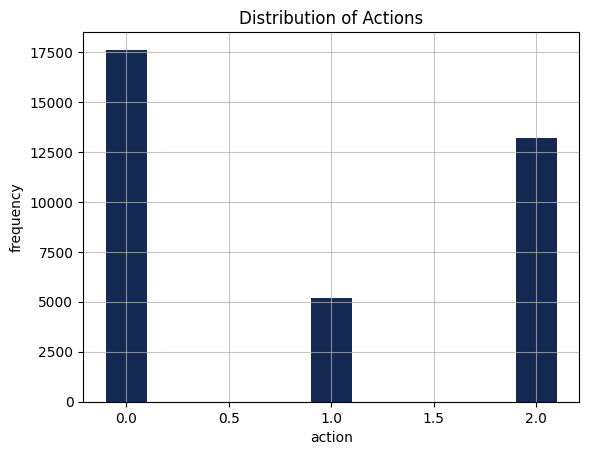

In [ ]:
plt.hist(acs, bins=[-0.5, 0.5, 1.5, 2.5], rwidth=0.2, color='#132952')

plt.title('Distribution of Actions')
plt.xlabel('action')
plt.ylabel('frequency')
plt.grid(alpha=0.75)
plt.show()

In [ ]:
np.histogram(a, bins=10)

(array([ 2, 18,  0,  0,  0,  0,  0,  0,  0,  1]),
 array([   30.      ,  1250.015625,  2470.03125 ,  3690.046875,
         4910.0625  ,  6130.078125,  7350.09375 ,  8570.109375,
         9790.125   , 11010.140625, 12230.15625 ]))

In [ ]:
np.linspace(30, 12230.16, 10)

array([   30.        ,  1385.57333333,  2741.14666667,  4096.72      ,
        5452.29333333,  6807.86666667,  8163.44      ,  9519.01333333,
       10874.58666667, 12230.16      ])

In [ ]:
a = np.array(test_pnl_SAC_realized) - np.array(test_pnl_SAC)

In [ ]:
fig = px.histogram(a,
                   nbins=13,
                   color_discrete_sequence=['#141757'])
fig.update_layout(bargap=0.5)
# fig.update_layout(template="plotly_white")
fig.update_xaxes(title_text="discrepancy")
fig.update_yaxes(title_text="frequency", hoverformat=".3f")

# Configure other layout properties
fig.update_layout(
    # title_text="Discrepancy",
    height=500,
    width=900,
    template="plotly_white",
    showlegend=False
)
fig.update_xaxes(showline=True, linewidth=1, linecolor='black', mirror=True)
fig.update_yaxes(showline=True, linewidth=1, linecolor='black', mirror=True)
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='LightGray')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='LightGray')
fig.update_layout(
    autosize=False,
    width=640,
    height=480,
)

NameError: name 'a' is not defined

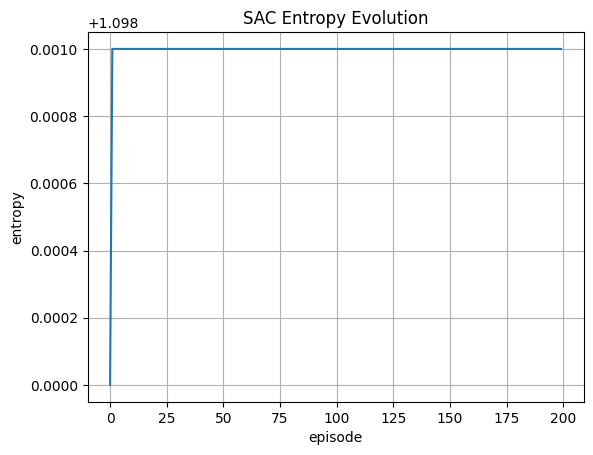

In [ ]:
plt.plot(range(len(entropy_list)), entropy_list)
plt.title('SAC Entropy Evolution')
plt.xlabel('episode')
plt.ylabel('entropy')
plt.grid(True)
plt.show()